In [1]:
# Libraries needed 
import h5py
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
import scipy
from scipy.spatial.distance import cdist


In [2]:
# upload data 
hdf5data_109 = h5py.File('../../Data/data_109.h5', 'r')
hdf5data_130 = h5py.File('../../Data/data_130.h5', 'r')
hdf5data_142 = h5py.File('../../Data/data_142.h5', 'r')
hdf5data_143 = h5py.File('../../Data/data_143.h5', 'r')

## Transferring detections into a dataframe 

In [3]:
def fill_rows_detections(detections, returndf):
    
    coord_detections = [np.array(vals[0].tolist()) for vals in detections]
    coord_detections = np.vstack(coord_detections)
        
    length_box = [vals[1] for vals in detections]
    width_box = [vals[2] for vals in detections]
    height_box = [vals[3] for vals in detections]
    angle_box = [vals[4] for vals in detections]
    
    returndf["X_box"] = coord_detections[:,0]
    returndf["Y_box"] = coord_detections[:,1]
    returndf["Z_box"] = coord_detections[:,2]
    returndf["length_box"], returndf["width_box"], returndf["height_box"] = length_box, width_box, height_box
    returndf["angle_box"] = angle_box
    
    return returndf

In [4]:
def df_detections(h5data,camera = None):
    
    timestamps = h5data['Timestamp']
    df = pd.DataFrame()
    
    for c, t in enumerate(timestamps):
        
        append_df = pd.DataFrame()
        
        d = h5data['Sequence'][str(c)]
        detection = np.asarray(d['Detections'])
        
        if detection.size:
            append_df = fill_rows_detections(detection, append_df)
            append_df['timestamp'] = t
            append_df['frame'] = c
        
            if camera is not None:
                append_df['camera'] = camera
        
            df = df.append(append_df)
    
    return df

In [5]:
df_109 = df_detections(hdf5data_109, 109)
df_109.reset_index(inplace=True, drop=True)
df_130 = df_detections(hdf5data_130, 130)
df_130.reset_index(inplace=True, drop=True)
df_142 = df_detections(hdf5data_142, 142)
df_142.reset_index(inplace=True, drop=True)
df_143 = df_detections(hdf5data_143, 143)
df_143.reset_index(inplace=True, drop=True)

In [6]:
def concatenate_dfs(dfs, sort_cols):
    
    df_to_concat = dfs
    df_complete = pd.concat(df_to_concat)
    df_complete.sort_values(by = sort_cols, inplace = True)
    df_complete.reset_index(inplace=True, drop=True)
    
    return df_complete

df_complete = concatenate_dfs([df_109,df_130,df_142,df_143] , ['frame', 'camera'])
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109
11741,-1.906789,-5.313489,-2.293509,3.833054,0.585950,0.395508,-0.462055,1.574333e+09,749,142
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142
11743,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143


## Frame visualization

In [7]:
def convert_to_image_space ( coordinates , world2cam , cam2im ):
    """ Input single set of coordinatetes """
    coord_4 = np.ones (4)
    coord_4[0:3] = coordinates
    cams_coord = ( np.matmul( world2cam , coord_4.T )).T
    cams_coord_4 = np.ones(4)
    
    cams_coord_4 [0:3] = cams_coord [0:3]
    ims_coord = ( np . matmul ( cam2im , cams_coord_4 .T )). T
    # Divide by z coordinate for some reason
    ims_coord [0] = ims_coord [0]/ ims_coord [2]
    ims_coord [1] = ims_coord [1]/ ims_coord [2]
    ims_coord = ims_coord [0:2]
    
    return ( ims_coord )


def visualize_frame_detections ( camera, frame_idx, figsize = None , s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])

    x_list = []
    y_list = []

    for point in detected_points:
    
        world_pos = np.array(point[0].tolist())
        fin_pos = convert_to_image_space(world_pos, camera['TMatrixWorldToCam'], camera['ProjectionMatrix'])
        x_list.append(fin_pos[0])
        y_list.append(fin_pos[1])

    # Show image
    a = np.asarray(frame['Image'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    plt.imshow(a, cmap = 'gist_gray', zorder = 1)
    plt.scatter(x_list, y_list, s = s, color = 'hotpink', zorder = 3)
    
    return

def visualize_frame_boxes ( camera, frame_idx, figsize = None, s = 100):
    """ Input camera file, frame index and size of dot in the picture (default is 100) """
    
    frame = camera['Sequence'][str(frame_idx)]
    detected_points = np.asarray(frame['Detections'])
    
    if figsize is not None: 
        plt.figure(figsize = figsize)
        
    
    for point in detected_points:
        # first face 
        unrotated_vertex1 = np.array([+ point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex2 = np.array([+ point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex3 = np.array([+ point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex4 = np.array([+ point['Length']/2, - point['Width']/2, + point['Height']/2])
        # second face 
        unrotated_vertex5 = np.array([- point['Length']/2, + point['Width']/2, + point['Height']/2])
        unrotated_vertex6 = np.array([- point['Length']/2, + point['Width']/2, - point['Height']/2])
        unrotated_vertex7 = np.array([- point['Length']/2, - point['Width']/2, - point['Height']/2])
        unrotated_vertex8 = np.array([- point['Length']/2, - point['Width']/2, + point['Height']/2])
        
        
        unrotated_vertex_list = [unrotated_vertex1, unrotated_vertex2, unrotated_vertex3, 
                                 unrotated_vertex4, unrotated_vertex5, unrotated_vertex6, 
                                 unrotated_vertex7, unrotated_vertex8]
        
        rotation_matrix = np.array([[np.cos(point['Angle']), -np.sin(point['Angle']), 0], 
                            [np.sin(point['Angle']), np.cos(point['Angle']), 0], 
                            [0,0,1]])
        
        rotated_vertex_list = np.array([rotation_matrix.dot(v) for v in unrotated_vertex_list])
        rotated_vertex_list = rotated_vertex_list + np.array([point['Pos']['X'], point['Pos']['Y'], point['Pos']['Z']])
        
        vertex_im_list = [convert_to_image_space(v, camera['TMatrixWorldToCam'], camera['ProjectionMatrix']) for v in rotated_vertex_list]
        
        
        combinations = [(i,i+1) for i in range(3)] + [(3,0)] + [(i,i+1) for i in range(4,7)] + [
            (7,4)] + [(i,i+4) for i in range(4)]
        
        for (i,j) in combinations: 
            vertex_x_list = [vertex_im_list[i][0],vertex_im_list[j][0]]
            vertex_y_list = [vertex_im_list[i][1],vertex_im_list[j][1]]
            plt.plot(vertex_x_list, vertex_y_list, color = 'b', zorder = 2)
        
        
        
    visualize_frame_detections ( camera, frame_idx, s = s )
    
    return

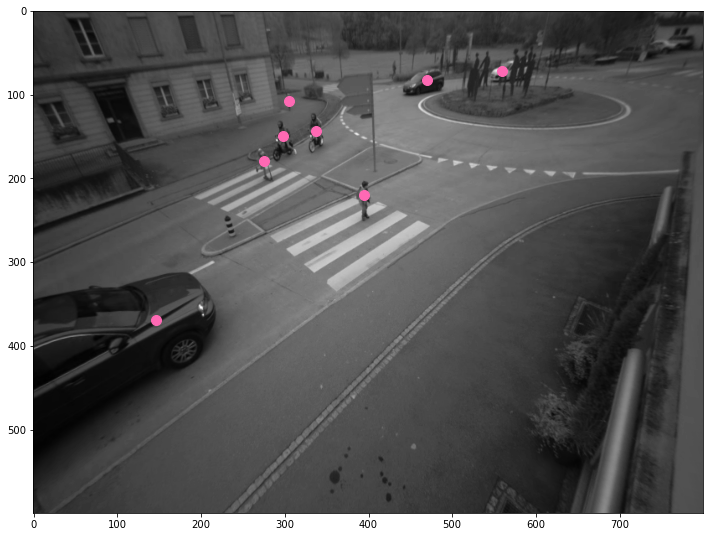

In [8]:
visualize_frame_detections(hdf5data_109,260, figsize = (12,12))

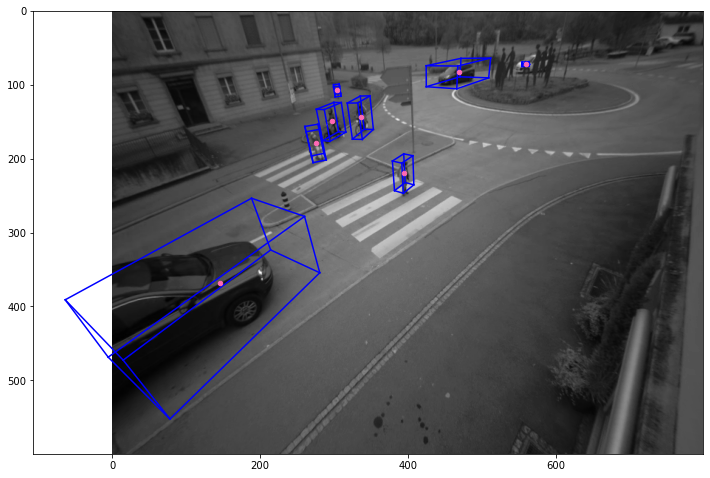

In [9]:
visualize_frame_boxes(hdf5data_109, 260, figsize = (12,12), s = 20)

## Use Df


In [10]:
df_complete

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
...,...,...,...,...,...,...,...,...,...,...
11740,-5.128264,26.316446,-1.150593,2.670343,1.157835,1.589266,-0.424405,1.574333e+09,749,109
11741,-1.906789,-5.313489,-2.293509,3.833054,0.585950,0.395508,-0.462055,1.574333e+09,749,142
11742,-1.142268,-3.922715,-2.524621,12.753714,0.377229,1.433762,-0.278929,1.574333e+09,749,142
11743,14.617583,-29.436074,-1.085488,5.046473,2.802799,1.898150,-1.309933,1.574333e+09,749,143


In [11]:
df_complete[df_complete['frame'] == 0]

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
5,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130
6,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143
7,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143
8,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143


,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
9,10.193464,-3.254121,-0.711990,1.412921,0.266124,0.460025,1.337511,1.574333e+09,1,109
10,-11.137152,15.415920,-0.911968,1.352618,0.546684,1.370234,0.708852,1.574333e+09,1,109
11,-9.487168,19.018149,-1.403667,2.751621,1.204600,1.533254,-0.508305,1.574333e+09,1,109
12,3.314025,27.995880,-1.186819,5.750861,2.279514,2.025559,1.530818,1.574333e+09,1,109
13,6.557454,26.324931,-0.863639,1.568051,0.584425,1.166256,0.442498,1.574333e+09,1,109
14,14.292184,-4.719566,-1.036344,3.694674,2.879994,1.621184,0.862217,1.574333e+09,1,130
15,27.366480,9.388028,-0.620996,2.423051,0.704623,1.189200,-0.820607,1.574333e+09,1,130
16,-8.244665,-16.619673,-2.642268,5.584267,0.324819,0.769942,-0.745784,1.574333e+09,1,142
17,10.460591,-32.968130,-1.340568,3.902771,2.242807,2.530253,-1.561048,1.574333e+09,1,143
18,2.427649,-32.079108,-0.605736,0.617645,0.512637,0.735474,-0.749255,1.574333e+09,1,143


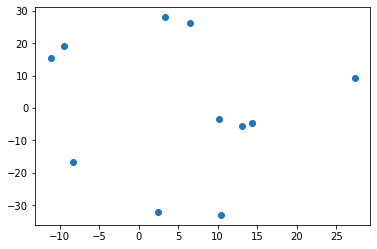

In [33]:
x = df_complete['X_box'][df_complete['frame'] == 1]
y = df_complete['Y_box'][df_complete['frame'] == 1]

plt.scatter(x,y)
df_complete[df_complete['frame'] == 1]

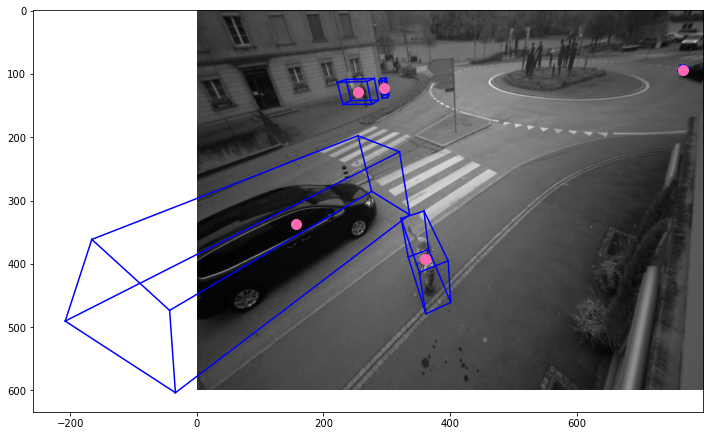

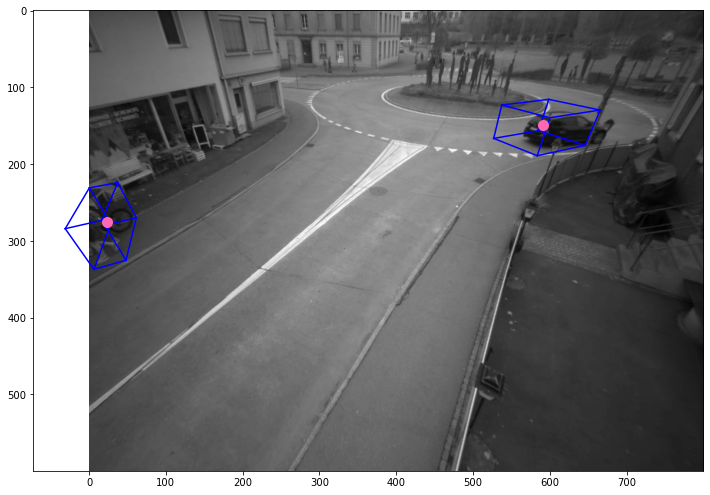

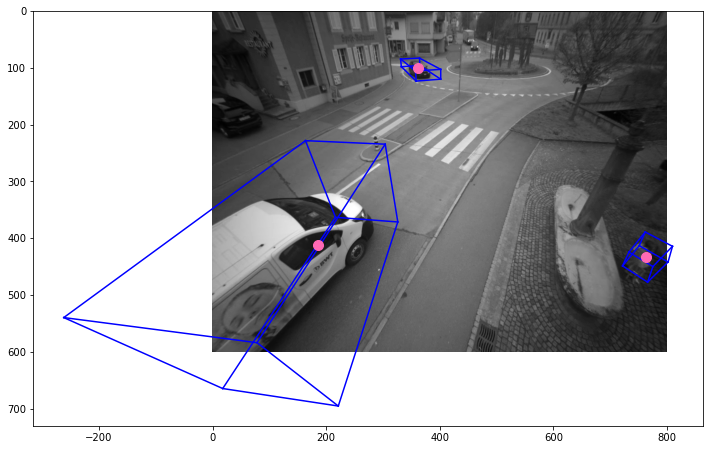

In [37]:
visualize_frame_boxes(hdf5data_109, 1, figsize = (12,12))
visualize_frame_boxes(hdf5data_130, 1, figsize = (12,12))
visualize_frame_boxes(hdf5data_143, 1, figsize = (12,12))

In [14]:
# Obj = { 'x' : 1, 'y': 1, 'z': 1, 'l': 10, 'w': 10, 'h' : 10, 'angle' : np.pi/2}

deltaT = 0.08
threshold = 5

class Track:
    
    def __init__(self, ID, OBJ, FRAME, threshold = threshold):
        self.ID = ID
        self.status = 'New'  #New, Pending, Active, Inactive
        self.objects = [OBJ]
        self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z
        self.frames = [FRAME]
        self.velocity = []
        self.type = None
        self.threshold = threshold
        self.filter = None
        global track_id
        track_id = ID + 1
    
    def update(self, OBJ, FRAME):
        self.objects.append(OBJ)
        self.frames.append(FRAME)
        self.x, self.y, self.z = OBJ.x, OBJ.y, OBJ.z #We should use KF.filter
        self.status = 'Active'
        
        return
    
    def set_status(self, status):
        self.status = status
        
        return
    
    def compute_vel ( self, OBJ ): #TO DO WITH KALMAN FILTERS NOT THIS SH*T
        vx = (OBJ['x'] - self.objects[-1]['x'])/deltaT
        vy = (OBJ['y'] - self.objects[-1]['y'])/deltaT
        vz = (OBJ['z'] - self.objects[-1]['z'])/deltaT
        
        self.velocity.append((vx,vy, vz))
        
        return
    
    def set_type( self, TYPE ):
        self.type = TYPE
        set_threshold()
        return
    
    def set_threshold (self):
        
        if type == 'car':
            self.threshold = 3
        
        else:
            self.threshold = 10
            
        return

class Object:
    def __init__(self, x, y, z, l, w, h, angle):
        self.x = x
        self.y = y
        self.z = z
        self.length = l
        self.width = w
        self.height = h
        self.angle = angle


In [25]:
#Fill this functions with chosen approach

#Using Nearest Neighbour -> not right, will always connect a track to an object
def track_detection_association(track_coord, obj_coord):
    ''' Function for association between detections and tracks'''
    
    dists = cdist(track_coord, obj_coord, 'euclidean') 
    associations = np.argmin(dists, axis=1)
    print(dists)
    print(associations)
    
    return associations

def associate(track_coord, tracks, status, obj_coord, obj_list):
    
    if track_coord.size:

        associations = track_detection_association(track_coord, obj_coord)
        for index, ass in enumerate(associations):
            tracks[status][index].update(obj_list[ass], frame_index)

        obj_list = np.delete(obj_list, associations)
    
    return tracks, obj_list

In [22]:
class Tracker:
    
    def __init__(self, dfs):
        self.tracks = {'Active': [], 'Pending': [], 'Inactive': [], 'New': []}
        self.dataframe = concatenate_dfs(dfs, ['frame', 'camera'])
        self.track_id = 0
        self.frame_index = 0
    
    def update_tracks(self):
        
        for tr in self.tracks['New'][::-1]:
            if tr.status != 'New':
                self.tracks['New'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Pending'][::-1]:
            if tr.status != 'Pending':
                self.tracks['Pending'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        for tr in self.tracks['Active'][::-1]:
            if tr.status != 'Active':
                self.tracks['Active'].remove(tr)
                self.tracks[tr.status].append(tr)
        
        return
    
    def next_step(self):
        self.frame_index += 1


In [26]:
TrackTrack = Tracker([df_109,df_130,df_142,df_143])
frame = TrackTrack.dataframe[TrackTrack.dataframe['frame'] == TrackTrack.frame_index]
display(frame)
### Setup at frame 0
obj_list = []

for index, row in frame.iterrows():
    obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], row['width_box'], row['height_box'], row['angle_box'])
    obj_list.append(obj)
    tr = Track(TrackTrack.track_id, obj, TrackTrack.frame_index)
    TrackTrack.tracks['New'].append(tr)


### New Frame
TrackTrack.next_step()
frame = TrackTrack.dataframe[TrackTrack.dataframe['frame'] == TrackTrack.frame_index]
frame.reset_index(inplace=True, drop=True)
display(frame)
obj_list = []

### Retrieve objects
for index, row in frame.iterrows():
    obj = Object(row['X_box'], row['Y_box'], row['Z_box'], row['length_box'], row['width_box'], row['height_box'], row['angle_box'])
    obj_list.append(obj)

obj_list = np.array(obj_list)

### Associate 
obj_coord = [[obj.x, obj.y, obj.z] for obj in obj_list]

# At first we use Active Tracks
track_act_coord = np.array([[t.x, t.y, t.z] for t in TrackTrack.tracks['Active']]) #We should use KF.predict here and not consider only the new set
TrackTrack.tracks, obj_list = associate(track_act_coord, TrackTrack.tracks, 'Active', obj_coord, obj_list)

#Then we use tracks set as New
track_new_coord = np.array([[t.x, t.y, t.z] for t in TrackTrack.tracks['New']]) #We should use KF.predict here and not consider only the new set
TrackTrack.tracks, obj_list = associate(track_new_coord, TrackTrack.tracks, 'New', obj_coord, obj_list)

#Then we use tracks set as Pending
track_pending_coord = np.array([[t.x, t.y, t.z] for t in TrackTrack.tracks['Pending']]) #We should use KF.predict here and not consider only the new set
TrackTrack.tracks, obj_list = associate(track_pending_coord, TrackTrack.tracks, 'Pending', obj_coord, obj_list)


TrackTrack.update_tracks()
print(TrackTrack.tracks)
print(obj_list)
for obj in obj_list:
    tr = Track(TrackTrack.track_id, obj, TrackTrack.frame_index)
    TrackTrack.tracks['New'].append(tr)

,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,-11.148409,15.363879,-0.941920,1.177285,0.561967,1.334849,0.631927,1.574333e+09,0,109
1,-9.560173,18.983654,-1.377405,3.325998,0.953963,1.498572,-0.120755,1.574333e+09,0,109
2,3.373729,28.175323,-1.134802,5.493111,1.930805,2.056836,1.514860,1.574333e+09,0,109
3,6.546980,26.314280,-0.862299,1.506848,0.592773,1.134711,0.424306,1.574333e+09,0,109
4,14.382445,-4.612707,-1.015361,4.811726,2.805154,1.550568,1.004918,1.574333e+09,0,130
5,27.471277,9.154471,-0.657809,2.640507,0.653304,1.245023,-0.802791,1.574333e+09,0,130
6,10.591985,-33.300211,-1.254730,3.106008,2.026976,2.356834,1.390347,1.574333e+09,0,143
7,2.417817,-32.064833,-0.609711,0.641007,0.489730,0.741013,-0.615712,1.574333e+09,0,143
8,13.233552,-5.117304,-0.707404,9.933850,2.673657,1.161759,1.067465,1.574333e+09,0,143


,X_box,Y_box,Z_box,length_box,width_box,height_box,angle_box,timestamp,frame,camera
0,10.193464,-3.254121,-0.711990,1.412921,0.266124,0.460025,1.337511,1.574333e+09,1,109
1,-11.137152,15.415920,-0.911968,1.352618,0.546684,1.370234,0.708852,1.574333e+09,1,109
2,-9.487168,19.018149,-1.403667,2.751621,1.204600,1.533254,-0.508305,1.574333e+09,1,109
3,3.314025,27.995880,-1.186819,5.750861,2.279514,2.025559,1.530818,1.574333e+09,1,109
4,6.557454,26.324931,-0.863639,1.568051,0.584425,1.166256,0.442498,1.574333e+09,1,109
5,14.292184,-4.719566,-1.036344,3.694674,2.879994,1.621184,0.862217,1.574333e+09,1,130
6,27.366480,9.388028,-0.620996,2.423051,0.704623,1.189200,-0.820607,1.574333e+09,1,130
7,-8.244665,-16.619673,-2.642268,5.584267,0.324819,0.769942,-0.745784,1.574333e+09,1,142
8,10.460591,-32.968130,-1.340568,3.902771,2.242807,2.530253,-1.561048,1.574333e+09,1,143
9,2.427649,-32.079108,-0.605736,0.617645,0.512637,0.735474,-0.749255,1.574333e+09,1,143


[[2.83224004e+01 6.10912991e-02 4.04062132e+00 1.92038909e+01
  2.08242256e+01 3.24126133e+01 3.89770509e+01 3.21600767e+01
  5.29442248e+01 4.93483480e+01 3.19458575e+01]
 [2.97517662e+01 3.92838624e+00 8.49075963e-02 1.57162820e+01
  1.77182449e+01 3.36287663e+01 3.81605281e+01 3.56500677e+01
  5.56760290e+01 5.24567348e+01 3.33278715e+01]
 [3.21636056e+01 1.93240183e+01 1.57901486e+01 1.96138462e-01
  3.69236846e+00 3.46597190e+01 3.04775093e+01 4.63017408e+01
  6.15531300e+01 6.02641806e+01 3.50365590e+01]
 [2.97927807e+01 2.07727048e+01 1.76244298e+01 3.65856389e+00
  1.49976604e-02 3.19862173e+01 2.68329611e+01 4.54454111e+01
  5.94133758e+01 5.85390680e+01 3.24687634e+01]
 [4.41422207e+00 3.24408152e+01 3.35905734e+01 3.44363075e+01
  3.19122390e+01 1.41443215e-01 1.90987243e+01 2.56671027e+01
  2.86272018e+01 2.99581057e+01 1.63603556e+00]
 [2.12720224e+01 3.91136955e+01 3.82593144e+01 3.06406812e+01
  2.70602120e+01 1.91395065e+01 2.58623873e-01 4.40893764e+01
  4.54328421e+01

In [ ]:
TrackTrack.tracks